In [31]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    log_loss
)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


In [35]:
train = pd.read_csv("/kaggle/input/mle-ese-mock/train (5).csv")   # CHANGE PATH
test  = pd.read_csv("/kaggle/input/mle-ese-mock/test (4).csv")    # CHANGE PATH

print(train.shape, test.shape)
train.head()


(2250, 16) (750, 15)


,id,fruit_type,weight_g,diameter_cm,color_grade,firmness_score,brix_level,acidity_ph,ripeness_index,bruise_area_pct,moisture_pct,shelf_life_days,harvest_age_days,storage_type,origin_region,quality_grade
0,0,mango,169.20,6.65,dull,9.37,15.88,3.77,0.93,0.00,79.43,9,13,ambient,local,Q2_fresh
1,1,banana,191.83,7.77,normal,6.63,12.32,3.84,0.71,1.94,77.63,8,19,cold,local,Q6_juice_low
2,2,mango,180.29,6.34,normal,6.70,8.31,3.66,0.63,10.52,80.19,7,16,ambient,import,NaN
3,3,banana,187.18,7.19,vibrant,6.99,13.36,3.76,0.65,5.62,73.60,9,11,ambient,local,Q5_juice_high
4,4,orange,185.25,8.12,normal,6.78,11.13,4.06,0.64,11.53,77.13,6,16,ambient,import,Q6_juice_low


In [36]:
print(train.isnull().sum())
print("Duplicates:", train.duplicated().sum())

train = train.drop_duplicates()


id                   0
fruit_type           0
weight_g             0
diameter_cm          0
color_grade          0
firmness_score       0
brix_level           0
acidity_ph           0
ripeness_index       0
bruise_area_pct      0
moisture_pct         0
shelf_life_days      0
harvest_age_days     0
storage_type         0
origin_region        0
quality_grade       12
dtype: int64
Duplicates: 0


In [38]:
TARGET_COL = "quality_grade"   # CHANGE
ID_COL = "id"

train = train.dropna(subset=[TARGET_COL])

print(train[TARGET_COL].value_counts())
print("Classes:", train[TARGET_COL].nunique())


quality_grade
Q1_premium_fresh    225
Q10_waste           225
Q3_export_grade     225
Q7_processing       225
Q9_feed             224
Q6_juice_low        224
Q5_juice_high       223
Q4_dessert          223
Q8_local_sale       223
Q2_fresh            221
Name: count, dtype: int64
Classes: 10


In [39]:
X = train.drop(columns=[ID_COL, TARGET_COL])
y = train[TARGET_COL]

numeric_features = X.select_dtypes(include=["int64","float64"]).columns
categorical_features = X.select_dtypes(include=["object","category"]).columns

print("Numerical:", numeric_features)
print("Categorical:", categorical_features)


Numerical: Index(['weight_g', 'diameter_cm', 'firmness_score', 'brix_level', 'acidity_ph',
       'ripeness_index', 'bruise_area_pct', 'moisture_pct', 'shelf_life_days',
       'harvest_age_days'],
      dtype='object')
Categorical: Index(['fruit_type', 'color_grade', 'storage_type', 'origin_region'], dtype='object')


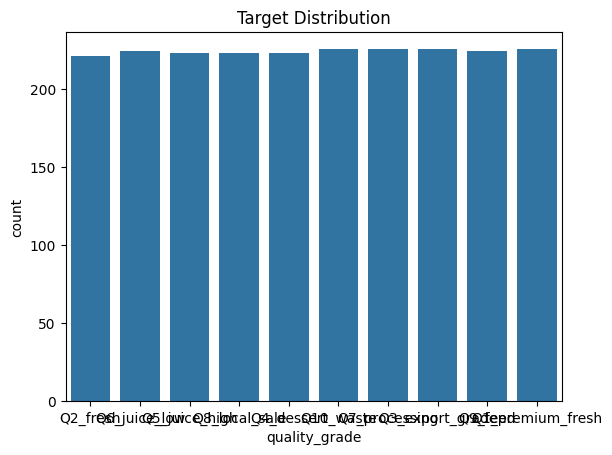

In [40]:
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()


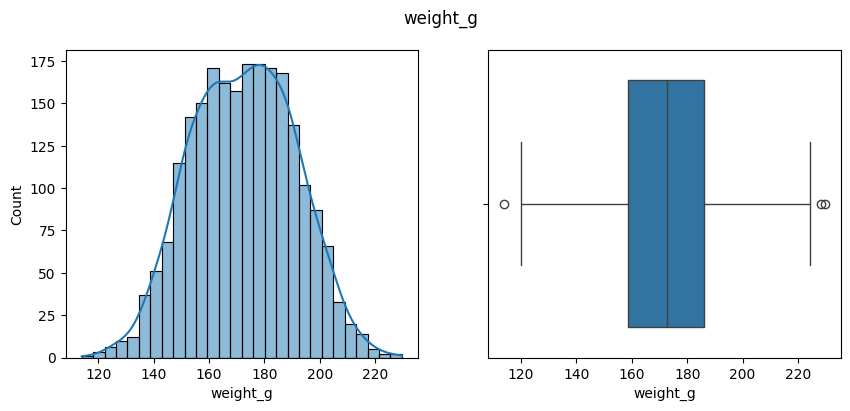

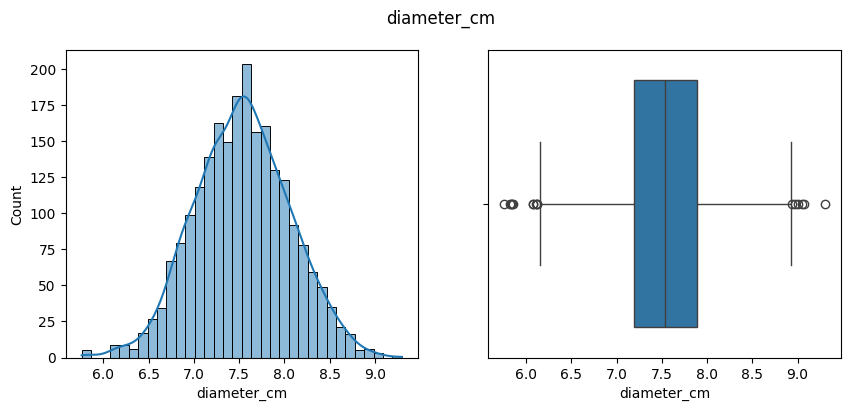

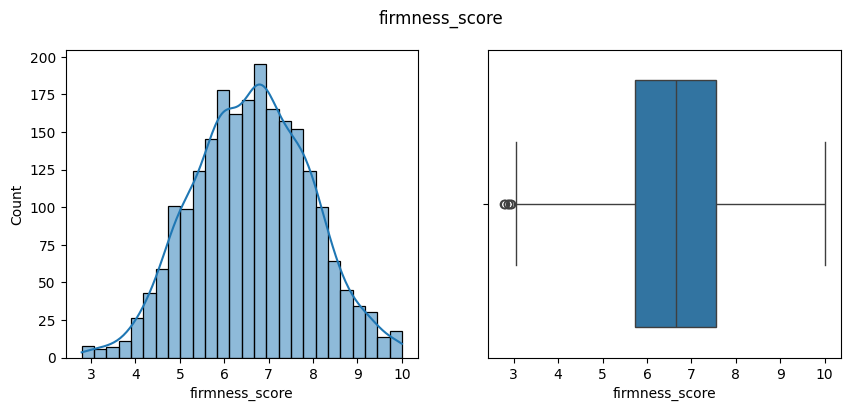

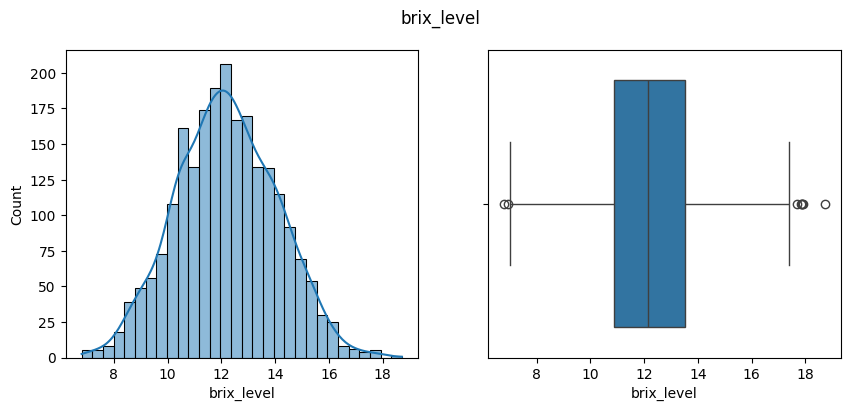

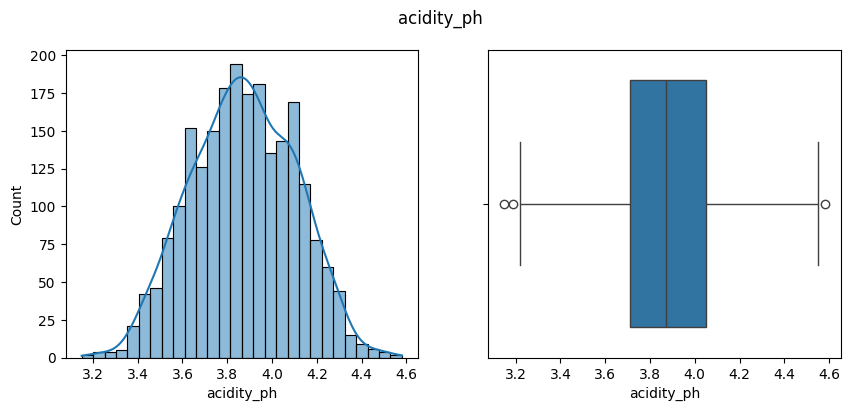

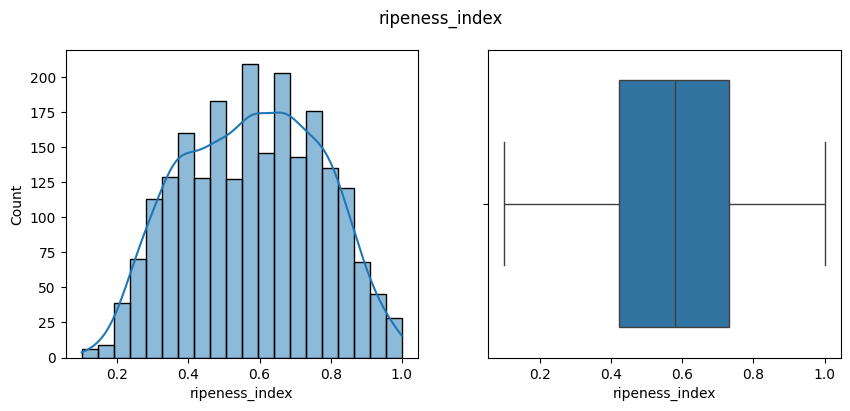

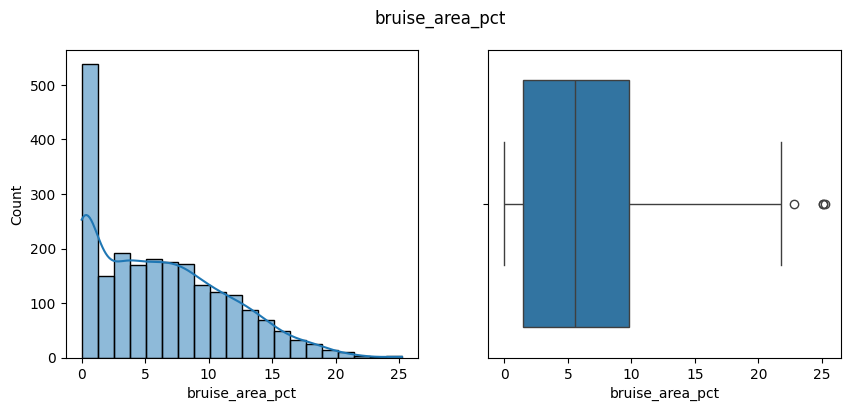

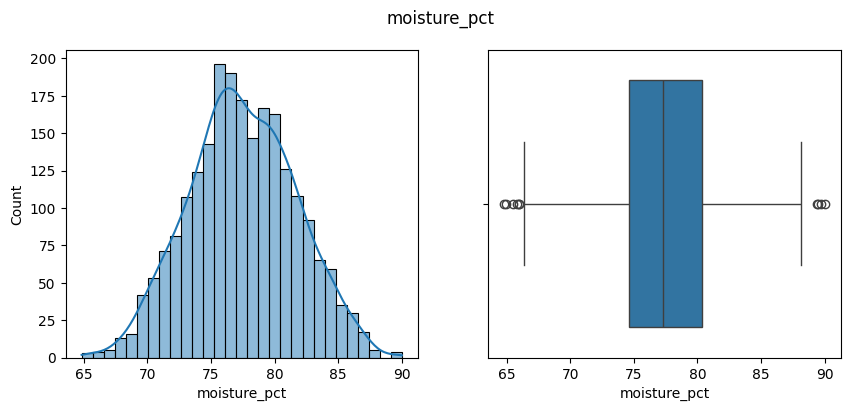

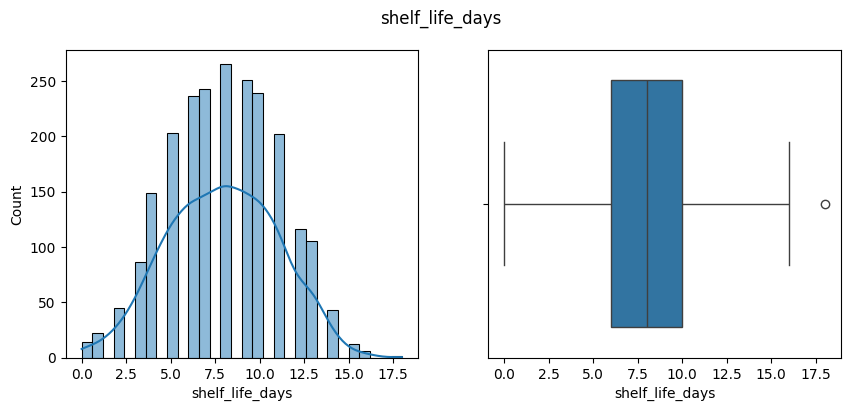

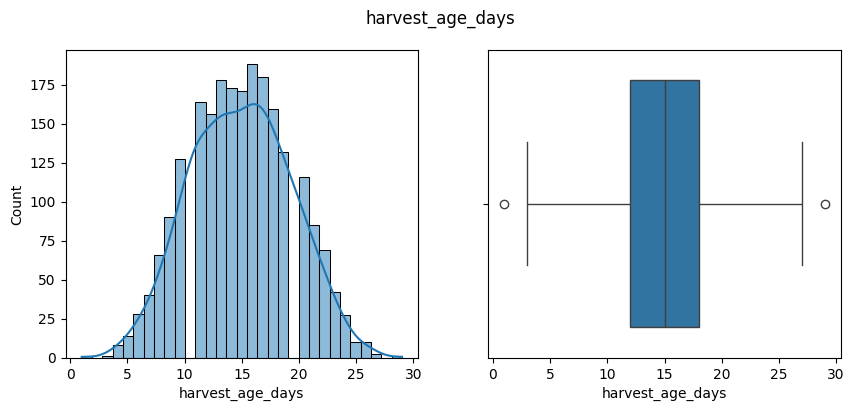

In [41]:
for col in numeric_features:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    sns.histplot(train[col], kde=True, ax=ax[0])
    sns.boxplot(x=train[col], ax=ax[1])
    plt.suptitle(col)
    plt.show()


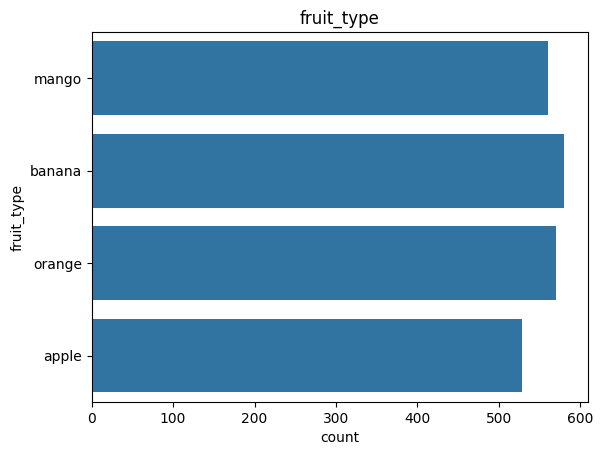

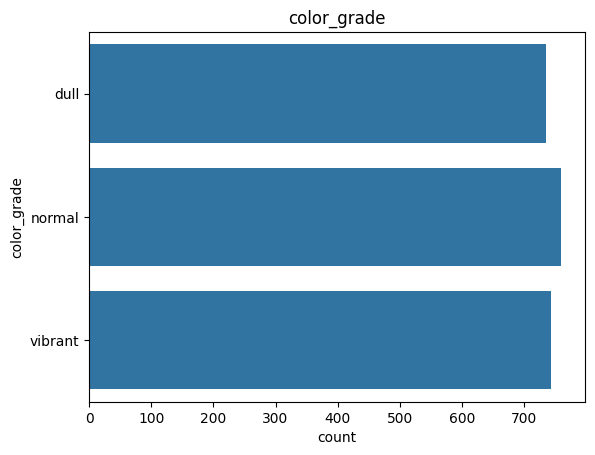

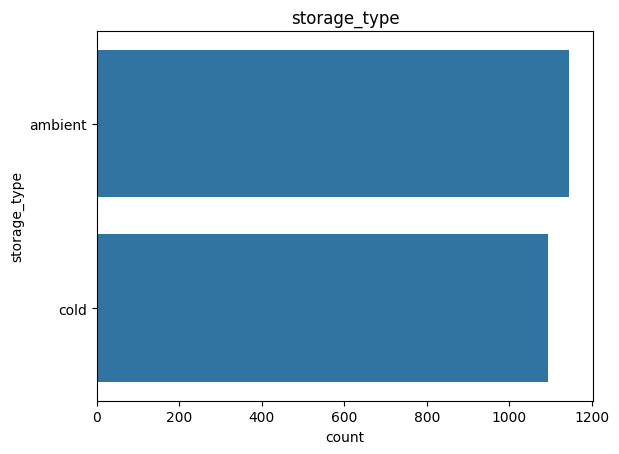

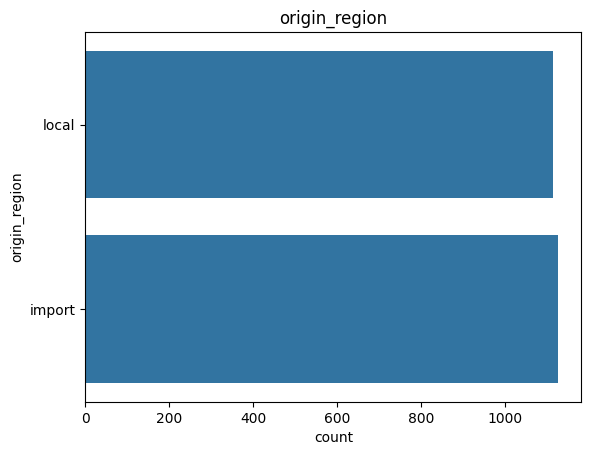

In [42]:
for col in categorical_features:
    sns.countplot(y=train[col])
    plt.title(col)
    plt.show()


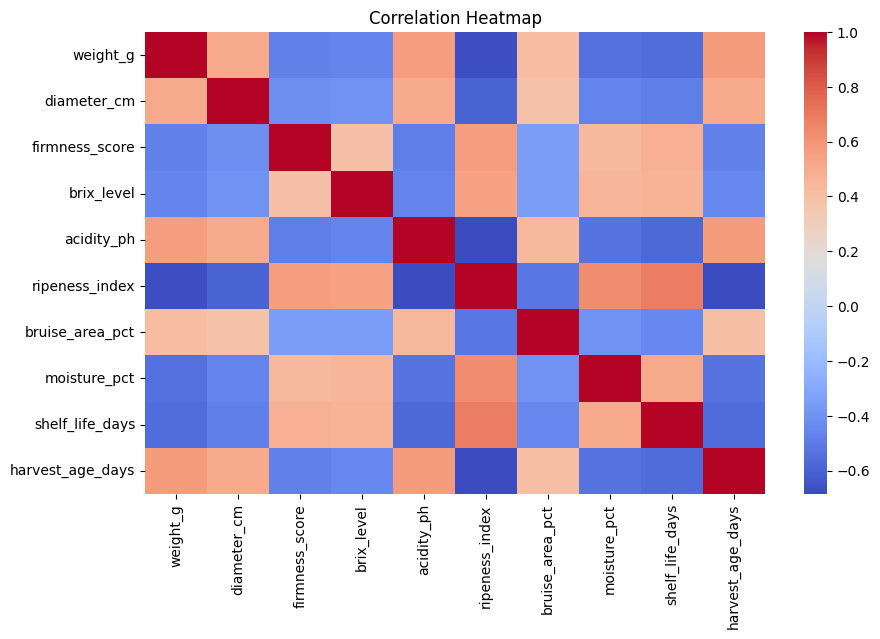

In [43]:
plt.figure(figsize=(10,6))
sns.heatmap(train[numeric_features].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


In [45]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])


In [46]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


In [47]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=10, class_weight="balanced", random_state=42
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        loss="log_loss",
        max_iter=100,
        learning_rate=0.05,
        max_depth=6,
        min_samples_leaf=30,
        l2_regularization=0.1,
        random_state=42
    ),
    "SVM": SVC(probability=True, class_weight="balanced")
}


In [48]:
results = {}

for name, model in models.items():
    print(f"\nTraining {name}")

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train_enc)

    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    acc = accuracy_score(y_test_enc, y_pred)
    loss = log_loss(y_test_enc, y_proba)

    results[name] = acc

    print("Accuracy:", acc)
    print("Log Loss:", loss)
    print(classification_report(y_test_enc, y_pred))



Training LogisticRegression
Accuracy: 0.49776785714285715
Log Loss: 1.1092565424810379
              precision    recall  f1-score   support

           0       0.71      0.82      0.76        45
           1       0.68      0.89      0.77        45
           2       0.47      0.34      0.39        44
           3       0.40      0.44      0.42        45
           4       0.37      0.39      0.38        44
           5       0.38      0.29      0.33        45
           6       0.47      0.51      0.49        45
           7       0.40      0.36      0.38        45
           8       0.45      0.38      0.41        45
           9       0.52      0.56      0.54        45

    accuracy                           0.50       448
   macro avg       0.48      0.50      0.49       448
weighted avg       0.49      0.50      0.49       448


Training DecisionTree
Accuracy: 0.35267857142857145
Log Loss: 3.0690620573867826
              precision    recall  f1-score   support

           0    

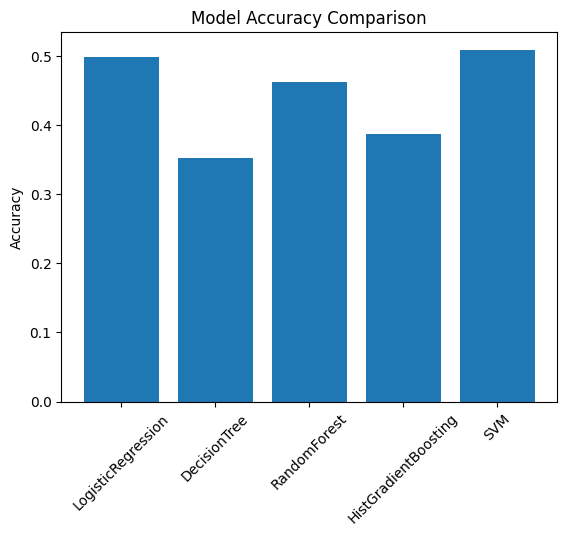

In [49]:
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


In [50]:
best_model_name = max(results, key=results.get)
print("Best Model:", best_model_name)

best_model = models[best_model_name]

final_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X_train, y_train_enc)


Best Model: SVM


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['weight_g', 'diameter_cm', 'firmness_score', 'brix_level', 'acidity_ph',
       'ripeness_index', 'bruise_area_pct', 'moisture_pct', 'shelf_life_days',
       'harvest_age_days'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['fruit_type', 'color_grade', 'storage_type', 'origin_region'], dtype='object'))])),
                ('model', SVC(class_weight='balanced', probability=True))])

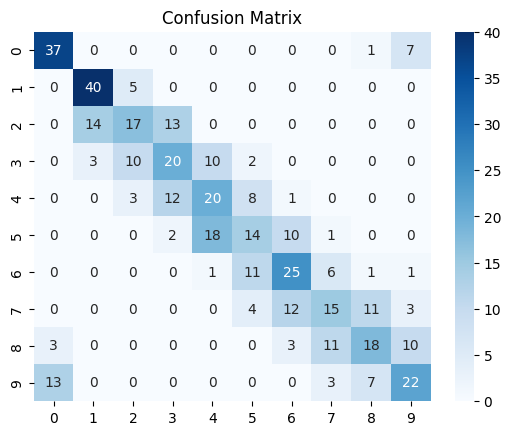

In [51]:
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)

cm = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

if len(le.classes_) == 2:
    fpr, tpr, _ = roc_curve(y_test_enc, y_proba[:,1])
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],"--")
    plt.title("ROC Curve")
    plt.show()


In [52]:
test_id = test[ID_COL]
test = test.drop(columns=[ID_COL])

test_proba = final_pipeline.predict_proba(test)

submission = pd.DataFrame(
    test_proba,
    columns=[f"Status_{cls}" for cls in le.classes_]
)

submission.insert(0, "id", test_id)
submission.to_csv("submission.csv", index=False)

submission.head()


,id,Status_Q10_waste,Status_Q1_premium_fresh,Status_Q2_fresh,Status_Q3_export_grade,Status_Q4_dessert,Status_Q5_juice_high,Status_Q6_juice_low,Status_Q7_processing,Status_Q8_local_sale,Status_Q9_feed
0,0,0.000422,0.007132,0.076964,0.336560,0.471022,0.102074,0.003673,0.001083,0.000611,0.000459
1,1,0.804001,0.000633,0.000672,0.000634,0.000485,0.000251,0.000181,0.001122,0.012447,0.179574
2,2,0.000643,0.689120,0.252510,0.053799,0.001072,0.000999,0.000404,0.000460,0.000434,0.000560
3,3,0.000284,0.004685,0.092359,0.460558,0.322615,0.109184,0.008428,0.001084,0.000491,0.000312
4,4,0.011163,0.000200,0.000196,0.000252,0.000526,0.001855,0.063024,0.363472,0.457854,0.101459
